# The module code:
The module should be quite independent of the rest of qpms, so there should be now no imports therefrom.
Therefore, it can be pasted (and modified and developed) below:

In [59]:
import numpy as np
import warnings
from enum import Enum

nx = None

class LatticeType(Enum):
    """
    All the five Bravais lattices in 2D
    """
    OBLIQUE=1
    RECTANGULAR=2
    SQUARE=4
    RHOMBIC=5
    EQUILATERAL_TRIANGULAR=3
    RIGHT_ISOSCELES=SQUARE
    PARALLELOGRAMMIC=OBLIQUE
    CENTERED_RHOMBIC=RECTANGULAR
    RIGHT_TRIANGULAR=RECTANGULAR
    CENTERED_RECTANGULAR=RHOMBIC
    ISOSCELE_TRIANGULAR=RHOMBIC
    RIGHT_ISOSCELE_TRIANGULAR=SQUARE
    HEXAGONAL=EQUILATERAL_TRIANGULAR

def reduceBasisSingle(b1, b2):
    """
    Lagrange-Gauss reduction of a 2D basis.
    cf. https://www.math.auckland.ac.nz/~sgal018/crypto-book/ch17.pdf
    inputs and outputs are (2,)-shaped numpy arrays
    The output shall satisfy |b1| <= |b2| <= |b2 - b1| 
    TODO doc
    
    TODO perhaps have the (on-demand?) guarantee of obtuse angle between b1, b2?
    TODO possibility of returning the (in-order, no-obtuse angles) b as well?
    """
    b1 = np.array(b1)
    b2 = np.array(b2)
    if b1.shape != (2,) or b2.shape != (2,):
        raise ValueError('Shape of b1 and b2 must be (2,)')
    B1 = np.sum(b1 * b1, axis=-1, keepdims=True)
    mu = np.sum(b1 * b2, axis=-1, keepdims=True) / B1
    b2 = b2 - np.rint(mu) * b1
    B2 = np.sum(b2 * b2, axis=-1, keepdims=True)
    while(np.any(B2 < B1)):
        b2t = b1
        b1 = b2
        b2 = b2t
        B1 = B2
        mu = np.sum(b1 * b2, axis=-1, keepdims=True) / B1
        b2 = b2 - np.rint(mu) * b1
        B2 = np.sum(b2*b2, axis=-1, keepdims=True)
    return(b1,b2)

def orderedReducedBasis(b1, b2):
    ''' blah blab blah
    |b1| is still the shortest possible basis vector,
        but if there would be obtuse angle between b1 and b2, b2 - b1 is returned
        in place of the original b2. In other words, b1, b2 and b2-b1 are 
    '''
    b1, b2 = reduceBasisSingle(b1,b2)
    
    if b3s - b2s - b1s > eps: # obtuse angle between b1 and b2
        pass
    pass
    #-------- zde jsem skončil ------------


def is_obtuse(b1, b2, tolerance=1e-13):
    b1s = np.sum(b1 ** 2)
    b2s = np.sum(b2 ** 2)
    b3 = b2 - b1
    b3s = np.sum(b3 ** 2)
    eps = tolerance * (b2s + b1s)
    return (b3s - b2s - b1s > eps)

def classifyLatticeSingle(b1, b2, tolerance=1e-13):
    """
    Given two basis vectors, returns 2D Bravais lattice type.
    Tolerance is relative.
    TODO doc
    """
    b1, b2 = reduceBasisSingle(b1, b2)
    b1s = np.sum(b1 ** 2)
    b2s = np.sum(b2 ** 2)
    b3 = b2 - b1
    b3s = np.sum(b3 ** 2)
    eps = tolerance * (b2s + b1s)
    # Avoid obtuse angle between b1 and b2. TODO This should be yet thoroughly tested.
    # TODO use is_obtuse here?
    if b3s - b2s - b1s > eps:
        b3 = b2
        b2 = b2 + b1
        # N. B. now the assumption |b3| >= |b2| is no longer valid
        #b3 = b2 - b1
        b2s = np.sum(b2 ** 2)
        b3s = np.sum(b3 ** 2)
        warnings.warn("obtuse angle between reduced basis vectors, the lattice type identification might is not well tested.")
    if abs(b2s - b1s) < eps or abs(b2s - b3s) < eps: # isoscele
        if abs(b3s - b1s) < eps:
            return LatticeType.EQUILATERAL_TRIANGULAR
        elif abs(b3s - 2 * b1s) < eps:
            return LatticeType.SQUARE
        else:
            return LatticeType.RHOMBIC
    elif abs(b3s - b2s - b1s) < eps:
        return LatticeType.RECTANGULAR
    else:
        return LatticeType.OBLIQUE

def range2D(maxN, mini=1, minj=0, minN = 0):
    """
    "Triangle indices"
    Generates pairs of non-negative integer indices (i, j) such that
    minN ≤ i + j ≤ maxN, i ≥ mini, j ≥ minj.
    TODO doc and possibly different orderings
    """
    for maxn in range(min(mini, minj, minN), maxN+1): # i + j == maxn
        for i in range(mini, maxn + 1):
            yield (i, maxn - i)

            
def generateLattice(b1, b2, maxlayer=5, include_origin=False, order='leaves'):
    b1, b2 = reduceBasisSingle(b1, b2)
    latticeType = classifyLatticeSingle(b1, b2)


    if latticeType is LatticeType.RECTANGULAR or latticeType is LatticeType.SQUARE:
        bvs = (b1, b2, -b1, -b2)
    else:
            # Avoid obtuse angle between b1 and b2. TODO This should be yet thoroughly tested.
        if is_obtuse(b1,b2):
            b3 = b2
            b2 = b2 + b1
            # N. B. now the assumption |b3| >= |b2| is no longer valid
            warnings.warn("obtuse angle between reduced basis vectors, the lattice generation might is not well tested.")
        else:
            b3 = b2 - b1
        bvs = (b1, b2, b3, -b1, -b2, -b3)
    cc = len(bvs) # "corner count"
    
    if order == 'leaves':
        indices = np.array(list(range2D(maxlayer)))
        ia = indices[:,0]
        ib = indices[:,1]
        cc = len(bvs) # 4 for square/rec,
        leaves = list()
        if include_origin: leaves.append(np.array([[0,0]]))
        for c in range(cc):
            ba = bvs[c]
            bb = bvs[(c+1)%cc]
            leaves.append(ia[:,nx]*ba + ib[:,nx]*bb)
        return np.concatenate(leaves)
    else: 
        raise ValueError('Lattice point order not implemented: ', order)

def cellCornersWS(b1, b2,):
    """
    Given basis vectors, returns the corners of the Wigner-Seitz unit cell
    (w1, w2, -w1, w2) for rectangular and square lattice or
    (w1, w2, w3, -w1, -w2, -w3) otherwise
    """
    def solveWS(v1, v2):
        v1x = v1[0]
        v1y = v1[1]
        v2x = v2[0]
        v2y = v2[1]
        lsm = ((-v1y, v2y), (v1x, -v2x))
        rs = ((v1x-v2x)/2, (v1y - v2y)/2)
        t = np.linalg.solve(lsm, rs)
        return np.array(v1)/2 + t[0]*np.array((v1y, -v1x))
    b1, b2 = reduceBasisSingle(b1, b2)
    latticeType = classifyLaticeSingle(b1, b2)
    if latticeType is LatticeType.RECTANGULAR or latticeType is LatticeType.SQUARE:
        return np.array( (
            (+b1+b2),
            (+b2-b1),
            (-b1-b2),
            (-b2+b1),
        )) / 2
    else:
        b3 = b2 - b1
        bvs = (b1, b2, b3, -b1, -b2, -b3)
        return np.array([solveWS(bvs[i], bvs[(i+1)%6]) for i in range(6)])

def cutWS(points, b1, b2, scale=1.):
    """ 
    From given points, return only those that are inside (or on the edge of)
    the Wigner-Seitz cell of a (scale*b1, scale*b2)-based lattice.
    """
    # TODO check input dimensions?
    b1, b2 = reduceBasisSingle(b1, b2)
    b3 = b2 - b1
    bvs = (b1, b2, b3, -b1, -b2, -b3)
    points = np.array(points)
    for b in bvs: 
        mask = (np.tensordot(points, b, axes=(-1, 0)) <= np.linalg.norm(b, ord=2) * scale/2)
        points = points[mask]
    return points

def filledWS(b1, b2, density=10, scale=1.):
    """
    TODO doc
    TODO more intelligent generation, anisotropy balancing etc.
    """
    b1, b2 = reduceBasisSingle(b1, b2)
    pass
    
    

def reciprocalBasis(a1, a2):
    pass

"""
TODO pro všechny rozptylové a modální simulace

Implementovat podporu následujících parametrů (v závorce implicitní hodnota):
    --bz_coverage (1.): 
        základní rozsah rovnoběžné části vlnového vektoru relativně k „délce“ 1. BZ. 
        Ve výchozím nastavení právě 1. BZ (tj. Wignerova-Seitzova 
        buňka v převráceném prostoru)
    --k_density (50.):
        základní počet bodů mezi středem a okrajem 1. BZ
    --bz_edge_width (0.):
        poloměr (relativně k vzdáleností mezi okrajem a středem 1. BZ) zhuštěného pásu kolem okraje 1. BZ
    --bz_edge_factor (8.):
        relativní hustota zhuštěného pásu (vzhledem k k_density)
    --bz_corner_width (0.):
        velikost zhuštěné oblasti kolem vrcholů 1. BZ (relativně k velikosti BZ)
    --bz_corner_factor (16.):
        relativní hustota zhuštěné „buněčky“ kolem 1. BZ (vzhledem k k_density)
    --bz_centre_width (0.):
        totéž kolem středu BZ
    --bz_centre_factor (8):
        totéž kolem středu BZ
    --bz_edge_twoside (?),
    --bz_corner_twoside (?):
        zda s pásem zasahovat přes okraj 1. BZ, nebo jen dovnitř

(nehoří) výhledově pořešit problém „hodně anisotropních“ mřížek (tj. kompensovat
rozdílné délky základních vektorů).

"""

'\nTODO pro všechny rozptylové a modální simulace\n\nImplementovat podporu následujících parametrů (v závorce implicitní hodnota):\n    --bz_coverage (1.): \n        základní rozsah rovnoběžné části vlnového vektoru relativně k „délce“ 1. BZ. \n        Ve výchozím nastavení právě 1. BZ (tj. Wignerova-Seitzova \n        buňka v převráceném prostoru)\n    --k_density (50.):\n        základní počet bodů mezi středem a okrajem 1. BZ\n    --bz_edge_width (0.):\n        poloměr (relativně k vzdáleností mezi okrajem a středem 1. BZ) zhuštěného pásu kolem okraje 1. BZ\n    --bz_edge_factor (8.):\n        relativní hustota zhuštěného pásu (vzhledem k k_density)\n    --bz_corner_width (0.):\n        velikost zhuštěné oblasti kolem vrcholů 1. BZ (relativně k velikosti BZ)\n    --bz_corner_factor (16.):\n        relativní hustota zhuštěné „buněčky“ kolem 1. BZ (vzhledem k k_density)\n    --bz_centre_width (0.):\n        totéž kolem středu BZ\n    --bz_centre_factor (8):\n        totéž kolem středu

# Playground:

## Lattice classification
TODO convert this to regular unit tests

In [60]:
%matplotlib inline
from matplotlib import pyplot as plt
bs = 100e-9
from math import sin, cos, sqrt
s2 = sqrt(2)
s3 = sqrt(3)
pi = np.pi

def draw_and_classify(b1, b2):
    f, ax = plt.subplots(figsize=(6,6))
    points = generateLattice(b1,b2, include_origin=True)
    ax.plot(points[:,0], points[:,1], 'ko-', lw=0.3)
    ax.plot((0,b1[0]), (0, b1[1]), '--', label = 'b1 input')
    ax.plot((0,b2[0]), (0, b2[1]), '--', label = 'b2 input')
    #ax.arrow(0,0,b1[0], b1[1]) # arrows seem to be broken at this scale
    #ax.arrow(0,0,b2[0], b2[1])
    altorig = (3*b1[0], 3*b1[1])
    b1, b2 = reduceBasisSingle(b1,b2)
    altorig = (3*b1[0], 3*b1[1])
    b3 = (b2[0]-b1[0], b2[1]-b1[1]) # yök
    ax.plot((altorig[0],altorig[0]+b1[0]), (altorig[1], altorig[1] + b1[1]), '--', label='b1 reduced')
    ax.plot((altorig[0],altorig[0]+b2[0]), (altorig[1], altorig[1] + b2[1]), '--', label='b2 reduced')
    ax.plot((altorig[0],altorig[0]+b3[0]), (altorig[1], altorig[1] + b3[1]), '--', label='b3 reduced')
    altorig = (3*b2[0], 3*b2[1])
    if is_obtuse(b1,b2):
        b3 = b2
        b2 = b2 + b1
        ax.plot((altorig[0],altorig[0]+b1[0]), (altorig[1], altorig[1] + b1[1]), '--', label='b1 n/o')
        ax.plot((altorig[0],altorig[0]+b2[0]), (altorig[1], altorig[1] + b2[1]), '--', label='b2 n/o')
        ax.plot((altorig[0],altorig[0]+b3[0]), (altorig[1], altorig[1] + b3[1]), '--', label='b3 n/o')
    ax.legend()
    #ax.arrow(altorig[0],altorig[1],altorig[0]+b1[0], altorig[1]+b1[1])
    #ax.arrow(altorig[0],altorig[1],altorig[0]+b2[0], altorig[1]+b2[1])
    #ax.arrow(altorig[0],altorig[1],altorig[0]+b3[0], altorig[1]+b3[1])
    ax.set_aspect('equal')
    return classifyLatticeSingle(b1,b2)

### Square lattices

<LatticeType.SQUARE: 4>

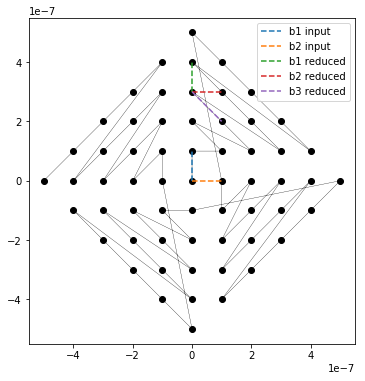

In [61]:
b1 = (0,bs)
b2 = (bs,0)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.SQUARE: 4>

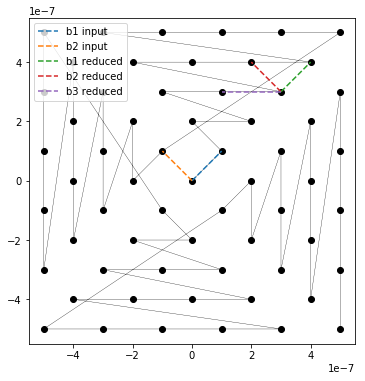

In [62]:
b1 = (bs,bs)
b2 = (-bs,bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.SQUARE: 4>

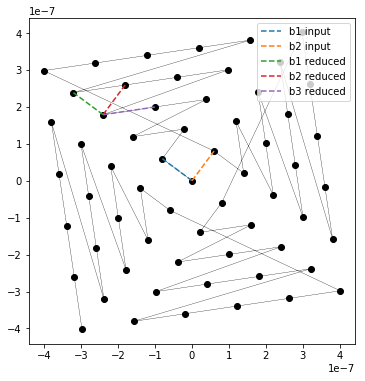

In [63]:
fi = np.random.rand() * 2*pi
b1 = (bs*sin(fi), bs*cos(fi))
b2 = (bs*cos(fi), -bs*sin(fi))
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

### Rectangular lattices

<LatticeType.RECTANGULAR: 2>

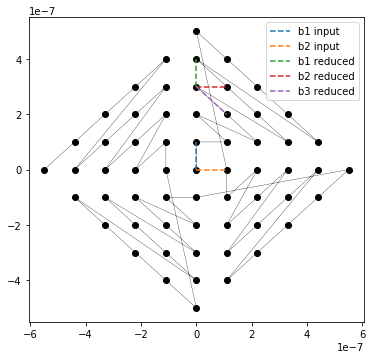

In [64]:
b1 = (0,bs)
b2 = (1.1*bs,0)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.RECTANGULAR: 2>

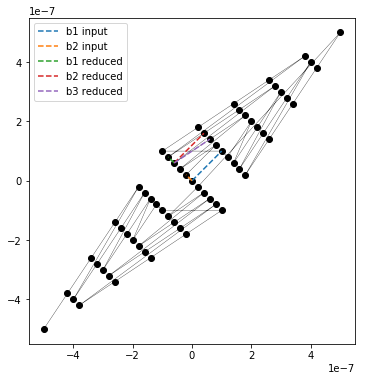

In [65]:
b1 = (bs,bs)
b2 = (-bs*.2,bs*.2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.RECTANGULAR: 2>

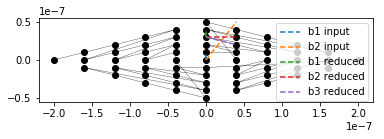

In [66]:
b1 = (0,.1*bs)
b2 = (.4*bs, .5*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.RECTANGULAR: 2>

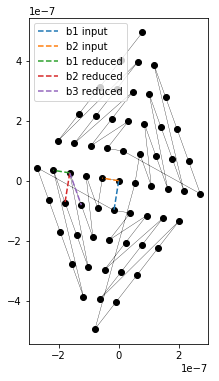

In [67]:
fi = np.random.rand() * 2*pi
fac = np.random.rand()  # For the "real" unit test, this may not be too near to one
b1 = (bs*sin(fi), bs*cos(fi))
b2 = (bs*cos(fi)*fac, -bs*sin(fi)*fac)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.RECTANGULAR: 2>

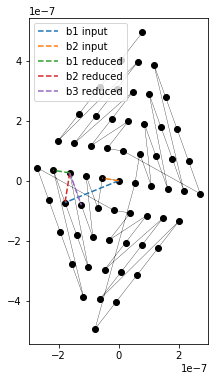

In [68]:
b1 = np.array(b1) + 3*np.array(b2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

### Equilateral triangular lattices

<LatticeType.EQUILATERAL_TRIANGULAR: 3>

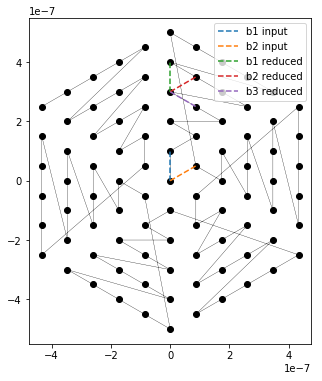

In [69]:
b1 = (0, bs)
b2 = (bs*s3/2, bs/2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: UserWarning: obtuse angle between reduced basis vectors, the lattice type identification might is not well tested.
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:135: UserWarning: obtuse angle between reduced basis vectors, the lattice generation might is not well tested.


<LatticeType.EQUILATERAL_TRIANGULAR: 3>

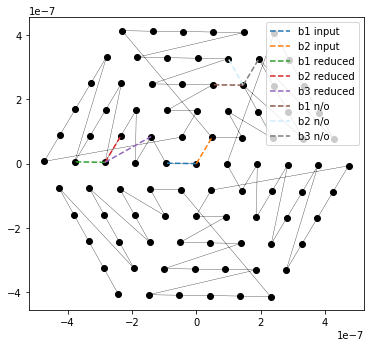

In [70]:
fi = np.random.rand() * 2*pi
fac = np.random.rand()  # For the "real" unit test, this may not be too near to one
b1 = (bs*sin(fi)*fac, bs*cos(fi)*fac)
b2 = (bs*sin(fi+2*pi/3)*fac, bs*cos(fi+2*pi/3)*fac)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: UserWarning: obtuse angle between reduced basis vectors, the lattice type identification might is not well tested.


<LatticeType.EQUILATERAL_TRIANGULAR: 3>

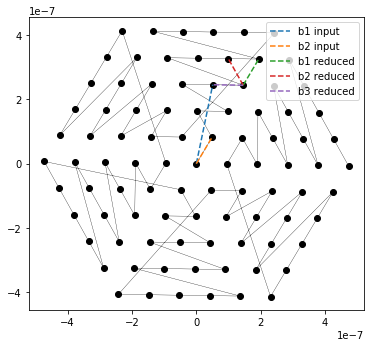

In [71]:
b1 = np.array(b1) + 3*np.array(b2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

### Rhombic lattices

<LatticeType.RHOMBIC: 5>

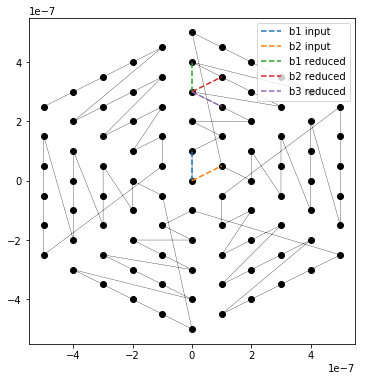

In [72]:
# case |b3| == |b2| > |b1|
b1 = (0,bs)
b2 = (bs, .5*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

<LatticeType.RHOMBIC: 5>

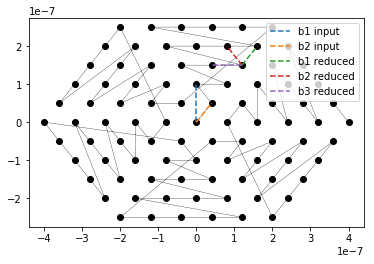

In [73]:
# case |b3| > |b2| == |b1|
b1 = (0,bs)
b2 = (.4*bs, .5*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

In [74]:
# TODO more

### Oblique lattices

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: UserWarning: obtuse angle between reduced basis vectors, the lattice type identification might is not well tested.
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:135: UserWarning: obtuse angle between reduced basis vectors, the lattice generation might is not well tested.


<LatticeType.OBLIQUE: 1>

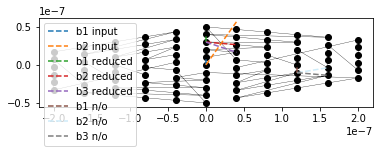

In [75]:
b1 = (0,.1*bs)
b2 = (.4*bs, .56575*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)